In [ ]:
from os.path import join as opj
import numpy as np
import pandas as pd
from nilearn.connectome import ConnectivityMeasure
from sklearn.linear_model import  ElasticNet
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.feature_selection import f_regression,GridSearchCV,SelectKBest,cross_val_predict
from scipy.stats import zscore
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, explained_variance_score
from model import *
from nilearn.connectome import vec_to_sym_matrix
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/times.ttf')
rc = {        
          "mathtext.fontset": 'stix',  # 保持使用STIX字体集来渲染数学字体，这与Times New Roman非常接近
    'font.family': 'serif',  # 设置字体族为serif，以便使用Times New Roman
    'font.serif': ['Times New Roman'],  # 指定Times New Roman作为serif字体
    'axes.unicode_minus': False  # 正常显示负号      
      } #设置字体样式 字体负号显示

In [2]:
def pipe_scale_fsel_elnet_search(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000,tol=0.0008),
                          p_grid={'fsel__k': [25, 50, 100, 1000,2000,3000,5000,7000,8000,9000],
                              'model__alpha': [.001, .005, .01, .05, .1, .5, 1, 5],
                              'model__l1_ratio': [0.0001, .25, .5, .75, 0.9999]         
                                   }):
                                      
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid
  
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000,tol=0.0008),
                          p_grid={'fsel__k': [2000],
                              'model__alpha': [.1],
                              'model__l1_ratio': [ 0.9999]         
                                   }):
                                      
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid
  


## model
model, p_grid = pipe_scale_fsel_elnet()
# model,p_grid = pipe_scale_fsel_elnet_search()


----------------------------------------------------------------
----------------------------------------------------------------
Fitting 54 folds for each of 1 candidates, totalling 54 fits
**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 2000, 'model__alpha': 0.1, 'model__l1_ratio': 0.9999}
** Score on full data as training set:	-0.09269405883168094
** Score on mean as model: -1.0
** Best Non-nested cross-validated score on test:	-0.5563420898823007
 Explained Variance: 0.4436579101176993
PearsonRResult(statistic=0.7090249826626673, pvalue=1.973617573050702e-09)


/home/lxm/.conda/envs/mine39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lxm/.conda/envs/mine39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


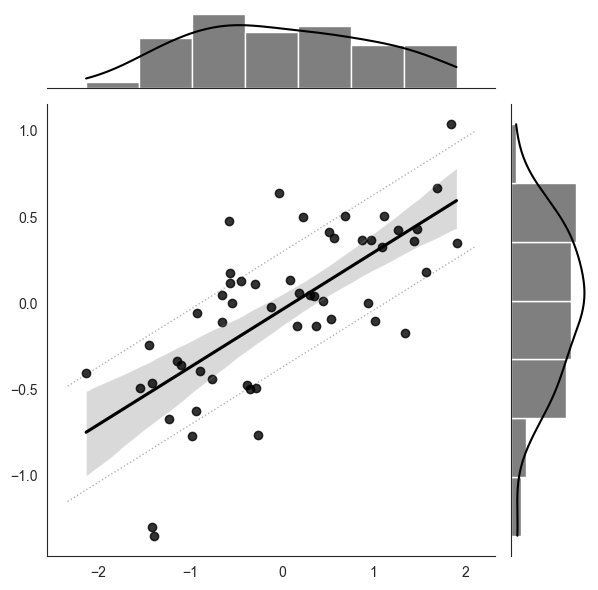

In [ ]:
all_ts = np.load('/mnt/lxm/lxm/post_braincord/scripts/5post_stats/1_all_analysis/validation_b_bs/final/d1_all_ts.npy')
qst = np.load('/mnt/lxm/lxm/post_braincord/scripts/5post_stats/1_all_analysis/validation_b_bs/final/d1_all_y.npy')

ind = np.where(np.isnan(qst))[0]
# 删除nan
qst_nonan = np.delete(qst, ind)
all_ts_nonan = np.delete(all_ts, ind, axis=0)
# 删除z>3的
qst_nonan_z = zscore(qst_nonan)
outliers_indices0 = np.where(np.abs(qst_nonan_z) > 3)
if len(outliers_indices0[0])>0:
    qst_nonan_z_filter = np.delete(qst_nonan_z,outliers_indices0)
    all_ts_nonan_z = np.delete(all_ts_nonan,outliers_indices0,axis=0)
else:
    qst_nonan_z_filter = qst_nonan_z
    all_ts_nonan_z = all_ts_nonan
if i < 10:
    qst_nonan_z_filter = qst_nonan_z_filter*(-1) # 反转疼痛敏感性
# 计算功能连接矩阵
correlation_measure = ConnectivityMeasure(kind='partial correlation',vectorize=True,discard_diagonal=True)
X = correlation_measure.fit_transform(all_ts_nonan_z)
Y = qst_nonan_z_filter
ncv = len(Y)
## fit model
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=ncv,
                scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                n_jobs=-1)
clf.fit(X, Y,)

cv_pred = cross_val_predict(clf.best_estimator_, X, Y, cv=ncv, groups=None, n_jobs=-1)                                 
print("**** Non-nested analysis ****")
print("** Best hyperparameters: " + str(clf.best_params_))

print("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=Y)))
print("** Score on mean as model: " + str(-mean_squared_error(np.repeat(Y.mean(), len(Y)), Y)))
print("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))
print(f" Explained Variance: " + str(
        1 - clf.best_score_ / -mean_squared_error(np.repeat(Y.mean(), len(Y)), Y)))
print(pearsonr(Y,cv_pred))
plot.plot_prediction(Y, cv_pred, sd=True, covar=[])

In [ ]:
    
from sklearn.model_selection import permutation_test_score


def pipe_scale_elnet(scaler=preprocessing.RobustScaler(),pca=PCA(),
                          model=clf.best_estimator_['model']):
    mymodel = Pipeline(
        [('scaler', scaler),
         ('model', model)])
    return mymodel

model = pipe_scale_elnet()

perm_res = permutation_test_score(estimator=model,
                                        X=X[:,clf.best_estimator_.named_steps['fsel'].get_support()],
                                        y=Y,
                                        cv=ncv,
                                        scoring='neg_mean_squared_error',
                                        n_permutations=1000,
                                        n_jobs=-1,
                                        verbose=1)
perm_res


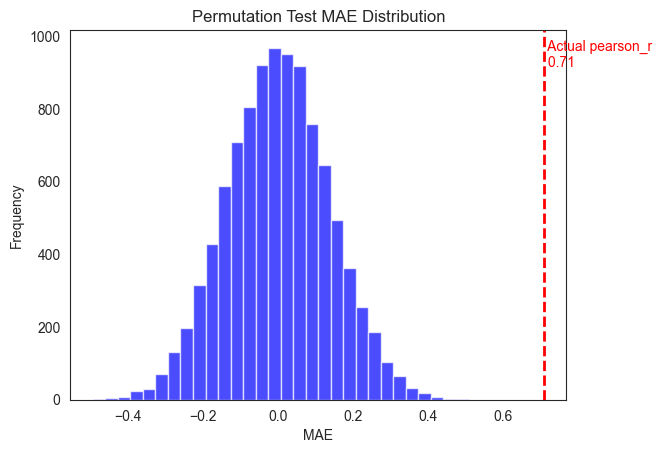

0.4436579101176993
0.0


In [9]:
initial_predictions = cv_pred
initial_pearson_r = pearsonr(Y, initial_predictions)[0]

# 置换测试
n_permutations = 10000
pearson_r_permutations = []
for _ in range(n_permutations):
    # 随机打乱标签
    shuffled_y = np.random.permutation(Y)

    # 计算并存储置换后的MAE
    # mae_permutations.append(mean_absolute_error(shuffled_y, initial_predictions))
    pearson_r_permutations.append(pearsonr(shuffled_y, initial_predictions)[0])

# 计算p值
p_value = np.sum(np.array(pearson_r_permutations) >= initial_pearson_r) / n_permutations

plt.hist(pearson_r_permutations, bins=30, color='blue', alpha=0.7)
plt.axvline(initial_pearson_r, color='red', linestyle='dashed', linewidth=2)
plt.title('Permutation Test MAE Distribution')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.text(initial_pearson_r, plt.ylim()[1]*0.9, f' Actual pearson_r\n {initial_pearson_r:.2f}', color='red')
plt.show()

print(r2_score(Y,initial_predictions))
print(np.sum(pearson_r_permutations > initial_pearson_r) /10000
)



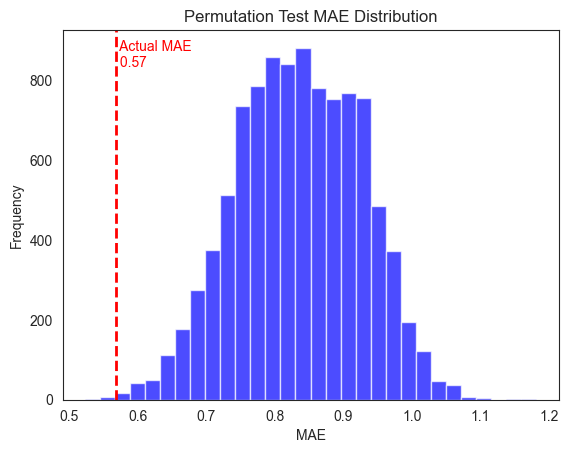

0.4436579101176993
0.0012


In [11]:
initial_predictions = cv_pred
initial_median_error = median_absolute_error(Y, initial_predictions)

# 置换测试
n_permutations = 10000
median_error_permutations = []
for _ in range(n_permutations):
    # 随机打乱标签
    shuffled_y = np.random.permutation(Y)

    # 计算并存储置换后的MAE
    # mae_permutations.append(mean_absolute_error(shuffled_y, initial_predictions))
    median_error_permutations.append(median_absolute_error(shuffled_y, initial_predictions))

# 计算p值
p_value = np.sum(np.array(median_error_permutations) <= initial_median_error) / n_permutations

plt.hist(median_error_permutations, bins=30, color='blue', alpha=0.7)
plt.axvline(initial_median_error, color='red', linestyle='dashed', linewidth=2)
plt.title('Permutation Test MAE Distribution')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.text(initial_median_error, plt.ylim()[1]*0.9, f' Actual MAE\n {initial_median_error:.2f}', color='red')
plt.show()

print(r2_score(Y,initial_predictions))
print(np.sum(median_error_permutations < initial_median_error) /10000
)



/tmp/ipykernel_2145743/840802520.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(np.sort(x), m*np.sort(x) + b+0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
/tmp/ipykernel_2145743/840802520.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(np.sort(x), m*np.sort(x) + b-0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)


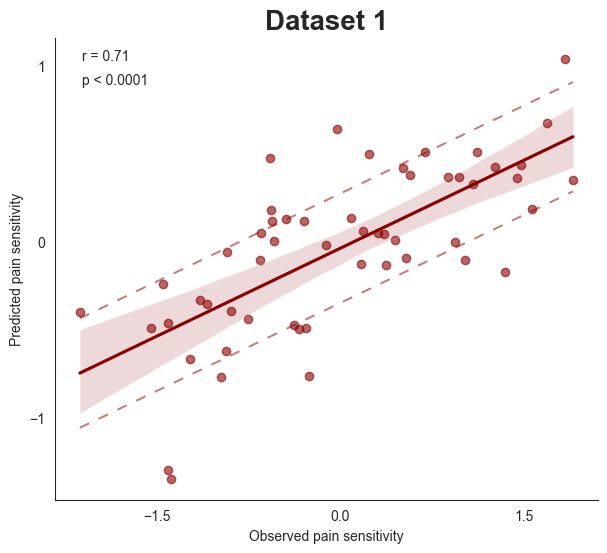

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error

color = 'darkred'
# For reproducibility
np.random.seed(0)

# Generate some random data that could resemble what we see in the figure
# For the purpose of example, we will create a dataset with a moderate positive correlation
x = Y
y = initial_predictions

plt.figure(figsize=(7, 6))
ax = sns.regplot(x=x, y=y, scatter_kws={'alpha':0.6,'color':color}, line_kws={'color':color})

# Customizing the plot with titles, labels
ax.set_title('Dataset 1', fontsize=20,fontweight='bold')
ax.set_xlabel('Observed pain sensitivity')
ax.set_ylabel('Predicted pain sensitivity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(3))  # 在x轴上最多显示5个刻度
ax.yaxis.set_major_locator(MaxNLocator(3))  # 在y轴上最多显示4个刻度

# Calculate correlation coefficient and p-value
correlation_coefficient = np.corrcoef(x, y)[0, 1]
from scipy import stats

# Annotate the plot with the correlation coefficient and p-value
ax.text(0.05, 0.95, f'r = {correlation_coefficient:.2f}', transform=ax.transAxes)
ax.text(0.05, 0.90, f'p < 0.0001', transform=ax.transAxes)
# ax.text(0.05, 0.90, f'p < 0.001', transform=ax.transAxes)

mae = mean_absolute_error(x, y)
m, b = np.polyfit(x, y, 1)

plt.plot(np.sort(x), m*np.sort(x) + b+0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
plt.plot(np.sort(x), m*np.sort(x) + b-0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
# plt.ylim(-1.3,1.3)
# plt.xlim(-3,3)
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(3))  # 在x轴上最多显示5个刻度
ax.yaxis.set_major_locator(MaxNLocator(3))  # 在y轴上最多显示4个刻度

# Show the plot
plt.show()

In [19]:
brain_label = pd.read_csv('/mnt/lxm/lxm/post_braincord/scripts/5post_stats/masks/MIST_122/MIST_122.csv',sep=',')['label'].values
# brain_label = pd.read_csv('/mnt/lxm/lxm/post_braincord/scripts/5post_stats/masks/MIST_122/MIST_122_yeo_9network.csv')['yeo_network'].values
spinal_label = spinal_label = ['C'+str(j)+'_'+i for j in range(1, 8) for i in ['D','V']]
labels = list(brain_label)+['pag','rvm','whole_grey'] + list(spinal_label)
featuremask = clf.best_estimator_.named_steps['fsel'].get_support()
# 获得连接权重
def get_weights(model, labels=labels, ):
    RES = np.zeros(int(len(labels)*(len(labels)-1)/2))

    featuremask = model.named_steps['fsel'].get_support()
    RES[featuremask] = model.named_steps['model'].coef_.flatten()
    
    print(np.sum(model.named_steps['model'].coef_!=0))
    
    RES_MAT = vec_to_sym_matrix(RES, diagonal=np.repeat(0, len(labels)))
    return RES_MAT

res_mat = get_weights(clf.best_estimator_)

id_A = np.where(res_mat)[0]
id_B = np.where(res_mat)[1]
reg_A = [labels[x] for x in np.where(res_mat)[0]]
reg_B = [labels[x] for x in np.where(res_mat)[1]]
weights = [x for x in res_mat[np.where(res_mat)]]

bc_weight = pd.DataFrame({'id_A': id_A,
                        'id_B': id_B,
                        'reg_A': reg_A,
                        'reg_B': reg_B,
                        'weights': weights})
bc_weight['abs_weights'] = bc_weight['weights'].abs()
bc_weight = bc_weight.sort_values('abs_weights', ascending=False)
bc_weight = bc_weight.reset_index()
bc_weight = bc_weight[bc_weight.index % 2 !=0]
bc_weight = bc_weight.reset_index()
# bc_weight.to_csv('/mnt/lxm/lxm/post_braincord/scripts/5post_stats/1_all_analysis/results_1108/bc_weight.csv', index=False)

bc_weight

29


,level_0,index,id_A,id_B,reg_A,reg_B,weights,abs_weights
0,1,10,16,79,PRC_v,L_FP_l,-0.205396,0.205396
1,3,1,4,132,MOTnet_am,C4_V,0.167338,0.167338
2,5,16,41,47,HIPP,CER5,-0.160306,0.160306
3,7,30,72,6,R_MOTnet_dl,L_MFgyr_pr,0.146354,0.146354
4,9,13,23,91,PCcor,R_PORB,-0.124130,0.124130
5,11,15,41,2,HIPP,CERVM,-0.123850,0.123850
6,13,49,119,109,L_VLPFcor,MOTnet_vl,-0.095052,0.095052
7,15,7,13,19,CER9_v,R_IPsul,-0.088030,0.088030
8,17,6,13,14,CER9_v,R_ANGgyr,0.066876,0.066876
9,19,23,55,130,MDVISnet_a,C3_V,0.060582,0.060582


# validation

In [20]:
def pipe_scale_elnet(scaler=preprocessing.RobustScaler(),pca=PCA(),
                        model=clf.best_estimator_['model']):
    mymodel = Pipeline(
        [('scaler', scaler),
        ('model', model)])
    return mymodel

model = pipe_scale_elnet()
featuremask = clf.best_estimator_.named_steps['fsel'].get_support()
model.fit(X[:,featuremask],Y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 ElasticNet(alpha=0.1, l1_ratio=0.9999, max_iter=100000,
                            tol=0.0008))])

In [26]:
d2_all_ts = np.load('/home/lxm/lxm/post_braincord/scripts/5post_stats/1_all_analysis/validation_b_bs/data/feature_D2.npy')
d2_y = np.load('/home/lxm/lxm/post_braincord/scripts/5post_stats/1_all_analysis/validation_b_bs/data/obs_D2.npy')

/tmp/ipykernel_2145743/3358139531.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(np.sort(x), m*np.sort(x) + b+0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
/tmp/ipykernel_2145743/3358139531.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(np.sort(x), m*np.sort(x) + b-0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)


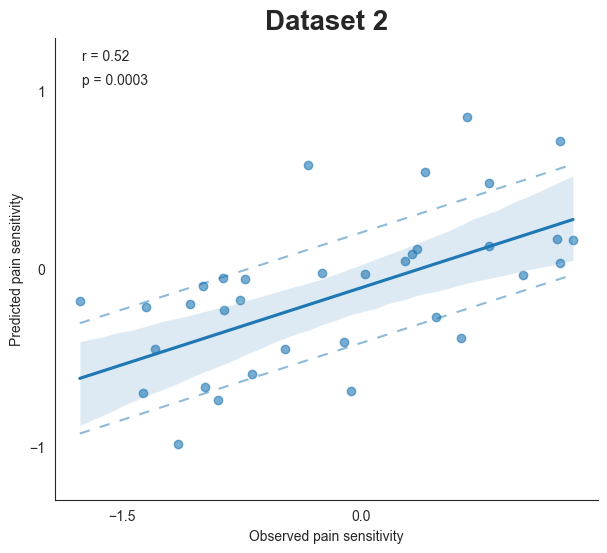

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error
color = 'tab:blue'
# For reproducibility
np.random.seed(0)

# Generate some random data that could resemble what we see in the figure
# For the purpose of example, we will create a dataset with a moderate positive correlation
x = d2_y
y = model.predict(d2_all_ts[:,featuremask])

plt.figure(figsize=(7, 6))
ax = sns.regplot(x=x, y=y, scatter_kws={'alpha':0.6,'color':color}, line_kws={'color':color})

# Customizing the plot with titles, labels
ax.set_title('Dataset 2', fontsize=20,fontweight='bold')
ax.set_xlabel('Observed pain sensitivity')
ax.set_ylabel('Predicted pain sensitivity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Calculate correlation coefficient and p-value
correlation_coefficient = np.corrcoef(x, y)[0, 1]
from scipy import stats

# Annotate the plot with the correlation coefficient and p-value
ax.text(0.05, 0.95, f'r = {correlation_coefficient:.2f}', transform=ax.transAxes)
ax.text(0.05, 0.90, f'p = 0.0003', transform=ax.transAxes)
# ax.text(0.05, 0.90, f'p < 0.001', transform=ax.transAxes)

mae = mean_absolute_error(x, y)
m, b = np.polyfit(x, y, 1)

plt.plot(np.sort(x), m*np.sort(x) + b+0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
plt.plot(np.sort(x), m*np.sort(x) + b-0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
plt.ylim(-1.3,1.3)
ax.xaxis.set_major_locator(MaxNLocator(3))  # 在x轴上最多显示5个刻度

# plt.xlim(-3,3)
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(3))  # 在x轴上最多显示5个刻度
ax.yaxis.set_major_locator(MaxNLocator(3))  # 在y轴上最多显示4个刻度

# Show the plot
plt.show()

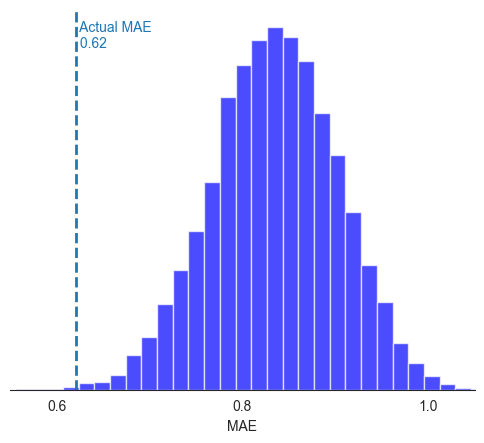

0.271529043494808
0.0012


In [31]:
initial_predictions = model.predict(d2_all_ts[:,featuremask])
initial_mae = mean_absolute_error(d2_y, initial_predictions)
# initial_pearson_r = pearsonr(y_real, initial_predictions)[0]
color = 'tab:blue'

# 置换测试
n_permutations = 10000
mae_permutations = []
for _ in range(n_permutations):
    # 随机打乱标签
    shuffled_y = np.random.permutation(d2_y)

    # 计算并存储置换后的MAE
    mae_permutations.append(mean_absolute_error(shuffled_y, initial_predictions))
    # pearson_r_permutations.append(pearsonr(shuffled_y, initial_predictions)[0])
fig, ax = plt.subplots(figsize=(6,7/(8.5/6)))

# 计算p值
p_value = np.sum(np.array(mae_permutations) <= initial_mae) / n_permutations
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticks([])
plt.xlim(0.55,1.05)
ax.xaxis.set_major_locator(MaxNLocator(3))  # 在x轴上最多显示5个刻度

plt.hist(mae_permutations, bins=30, color='blue', alpha=0.7)
plt.axvline(initial_mae, color=color, linestyle='dashed', linewidth=2)
# plt.title('Permutation Test MAE Distribution')
plt.xlabel('MAE')
# plt.ylabel('Frequency')
plt.text(initial_mae, plt.ylim()[1]*0.9, f' Actual MAE\n {initial_mae:.2f}', color=color)
plt.show()

print(r2_score(d2_y,initial_predictions))
print(np.sum(mae_permutations < initial_mae) /10000
)

In [32]:
d3_all_ts = np.load('/home/lxm/lxm/post_braincord/scripts/5post_stats/1_all_analysis/validation_b_bs/data/feature_D3.npy')
d3_y = np.load('/home/lxm/lxm/post_braincord/scripts/5post_stats/1_all_analysis/validation_b_bs/data/obs_D3.npy')

/tmp/ipykernel_2145743/1172886461.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(np.sort(x), m*np.sort(x) + b+0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
/tmp/ipykernel_2145743/1172886461.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(np.sort(x), m*np.sort(x) + b-0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)


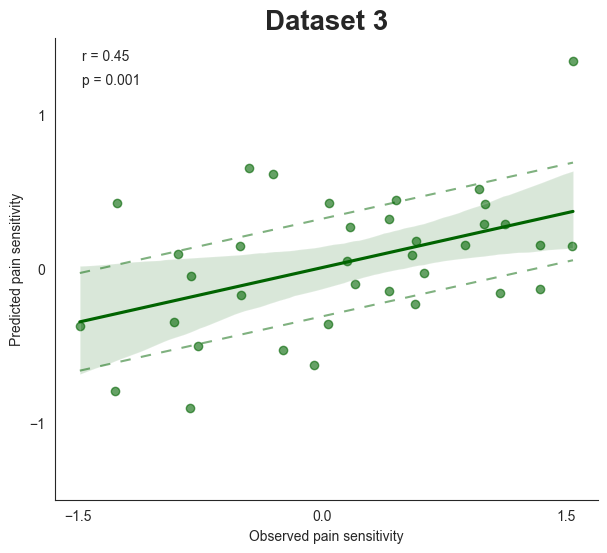

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error

color = 'darkgreen'
# For reproducibility
np.random.seed(0)

# Generate some random data that could resemble what we see in the figure
# For the purpose of example, we will create a dataset with a moderate positive correlation
x = d3_y
y = model.predict(d3_all_ts[:,featuremask])

plt.figure(figsize=(7, 6))
ax = sns.regplot(x=x, y=y, scatter_kws={'alpha':0.6,'color':color}, line_kws={'color':color})

# Customizing the plot with titles, labels
ax.set_title('Dataset 3', fontsize=20,fontweight='bold')
ax.set_xlabel('Observed pain sensitivity')
ax.set_ylabel('Predicted pain sensitivity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Calculate correlation coefficient and p-value
correlation_coefficient = np.corrcoef(x, y)[0, 1]
from scipy import stats

# Annotate the plot with the correlation coefficient and p-value
ax.text(0.05, 0.95, f'r = {correlation_coefficient:.2f}', transform=ax.transAxes)
ax.text(0.05, 0.90, f'p = {p_value:.3f}', transform=ax.transAxes)

mae = mean_absolute_error(x, y)
m, b = np.polyfit(x, y, 1)

plt.plot(np.sort(x), m*np.sort(x) + b+0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
plt.plot(np.sort(x), m*np.sort(x) + b-0.5*mae, 'g--',color=color, dashes=(5,5),alpha=0.5)
plt.ylim(-1.5,1.5)
# plt.xlim(-3,3)
ax.xaxis.set_major_locator(MaxNLocator(3))  # 在x轴上最多显示5个刻度
ax.yaxis.set_major_locator(MaxNLocator(3))  # 在y轴上最多显示4个刻度

# Show the plot
plt.show()


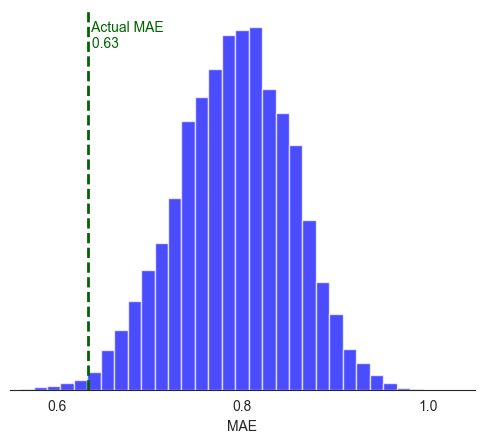

0.17916026161726895
0.0061


In [34]:
initial_predictions = model.predict(d3_all_ts[:,featuremask])
initial_mae = mean_absolute_error(d3_y, initial_predictions)
# initial_pearson_r = pearsonr(y_real, initial_predictions)[0]

# 置换测试
n_permutations = 10000
mae_permutations = []
for _ in range(n_permutations):
    # 随机打乱标签
    shuffled_y = np.random.permutation(d3_y)

    # 计算并存储置换后的MAE
    mae_permutations.append(mean_absolute_error(shuffled_y, initial_predictions))
    # pearson_r_permutations.append(pearsonr(shuffled_y, initial_predictions)[0])
fig, ax = plt.subplots(figsize=(6,7/(8.5/6)))

# 计算p值
p_value = np.sum(np.array(mae_permutations) <= initial_mae) / n_permutations
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticks([])
plt.xlim(0.55,1.05)
ax.xaxis.set_major_locator(MaxNLocator(3))  # 在x轴上最多显示5个刻度

plt.hist(mae_permutations, bins=30, color='blue', alpha=0.7)
plt.axvline(initial_mae, color=color, linestyle='dashed', linewidth=2)
# plt.title('Permutation Test MAE Distribution')
plt.xlabel('MAE')
# plt.ylabel('Frequency')
plt.text(initial_mae, plt.ylim()[1]*0.9, f' Actual MAE\n {initial_mae:.2f}', color=color)
plt.show()

print(r2_score(d3_y,initial_predictions))
print(np.sum(mae_permutations < initial_mae) /10000
)